# Visualization of Health Insurance Marketplace Dataset : Jesse Tackett

In [2]:
import matplotlib as mat
import pymongo as mongo
import matplotlib.pyplot as plt
import pandas as pd

print("Libraries Imported")

Libraries Imported


In [3]:
client = mongo.MongoClient()
print("Database Loaded")

Database Loaded


# Question A:1 ServiceAreaName
## A) Use “Service Area Dataset” from MongoDB. Find and plot the count of ServiceAreaName, SourceName , and BusinessYear across the country each state?

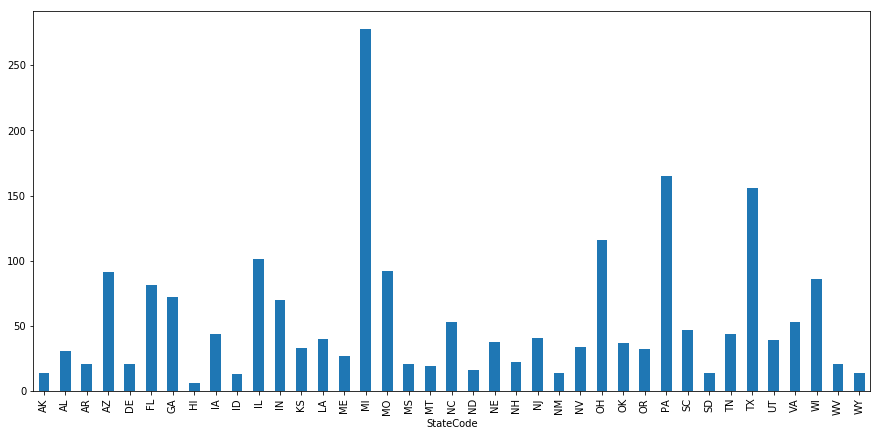

In [125]:
db = client.HealthInsuranceMarketplace
serviceArea = db.ServiceArea

dfServiceAreaName = pd.DataFrame(list(serviceArea.find()))#Grab all of Service Area and make it a dataframe
df_final = dfServiceAreaName.groupby("StateCode")['ServiceAreaName'].nunique()
# ^ This line takes all the info and just makes it only show the distinct counts of Service Area Name within each State code

df_final.plot(y=['ServiceAreaName'],x=['StateCode'],kind="bar",figsize=(15,7))#Of corse plot the dataframe

client.close()

# Question A:2 SourceName
## A) Use “Service Area Dataset” from MongoDB. Find and plot the count of ServiceAreaName, SourceName , and BusinessYear across the country each state?

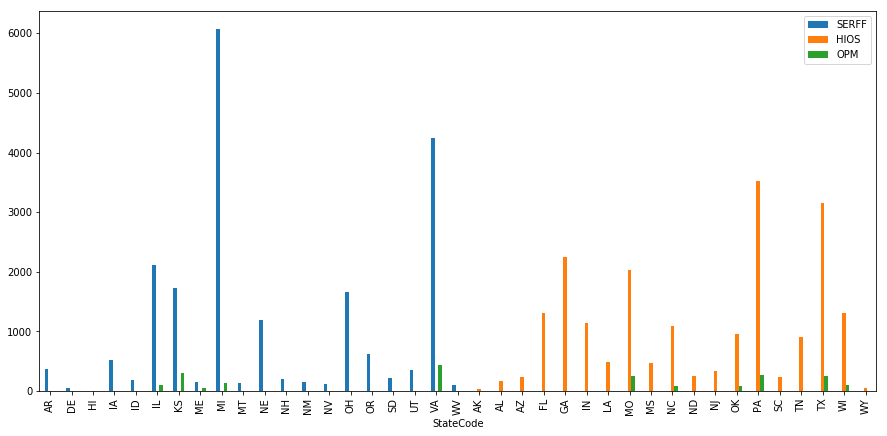

In [124]:
db = client.HealthInsuranceMarketplace
serviceArea = db.ServiceArea

projection = {'SourceName':1,'StateCode':1,'_id':0}#This is used to only grab what is needed
dfList = []#empty list for later use
snList = list(serviceArea.distinct('SourceName'))#List of distinct values of Source Name

for i in snList:#Use each source name to only grab states related to them
    dfList.append(pd.DataFrame(list(serviceArea.find({'SourceName':i}, projection))))

client.close()
count = -1
for i in snList:
    count += 1
    dfList[count] = dfList[count].groupby(['StateCode']).count()
    # ^ takes each SourceName dataframe and groups by state and counts the SourceName
    dfList[count].rename(columns = {'SourceName':i}, inplace = True)
    # ^ takes each column of SourceName counts in the dataframes and names it the corresponding Source Name 


df_temp = pd.merge(dfList[0], dfList[1], on='StateCode', how='outer')
df_final = pd.merge(df_temp, dfList[2], on='StateCode', how='outer')
# ^ This block of code does outter joins on the dataframes to keep all states

df_final.plot.bar(figsize=(15,7))
#print(df_final)

# Question A:3 BusinessYear
## A) Use “Service Area Dataset” from MongoDB. Find and plot the count of ServiceAreaName, SourceName , and BusinessYear across the country each state?

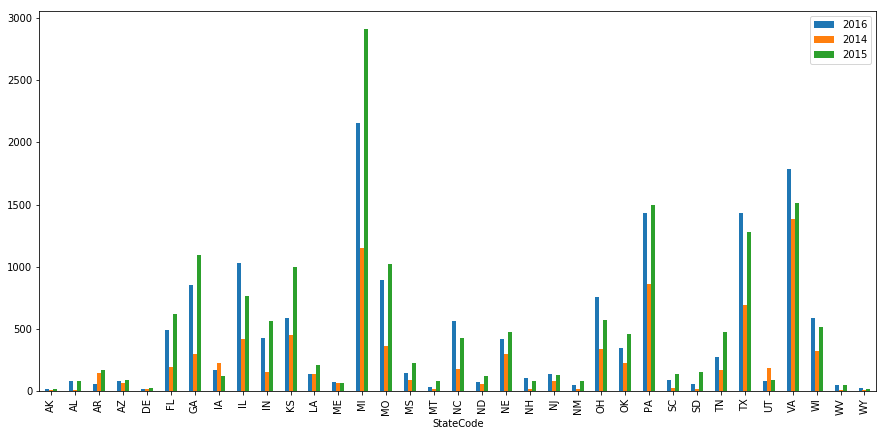

In [5]:
db = client.HealthInsuranceMarketplace
serviceArea = db.ServiceArea

projection = {'BusinessYear':1,'StateCode':1,'_id':0}#This is used to only grab what is needed
dfList = []#empty list for later use
yrList = list(serviceArea.distinct('BusinessYear'))#List of distinct values of Business Year

for i in range(len(yrList)):#Use each Business Year to only grab states related to them
    dfList.append(pd.DataFrame(list(serviceArea.find({'BusinessYear':yrList[i]}, projection))))

client.close()
for i in range(len(yrList)):
    dfList[i] = dfList[i].groupby(['StateCode']).count()
    # ^ takes each Business Year dataframe and groups by state and counts the Business Year
    dfList[i].rename(columns = {'BusinessYear':f'{yrList[i]}'}, inplace = True)
    # ^ takes each column of Business Year counts in the dataframes and names it the corresponding Business Year 

df_temp = pd.merge(dfList[0], dfList[1], on='StateCode')
df_final = pd.merge(df_temp, dfList[2], on='StateCode')
# ^ This block of code does outter joins on the dataframes to keep all state

df_final.plot.bar(figsize=(15,7))
#print(df_final)

# B) Use “Service Area Dataset” from MongoDB. Find and plot the count of “sources” across the country.

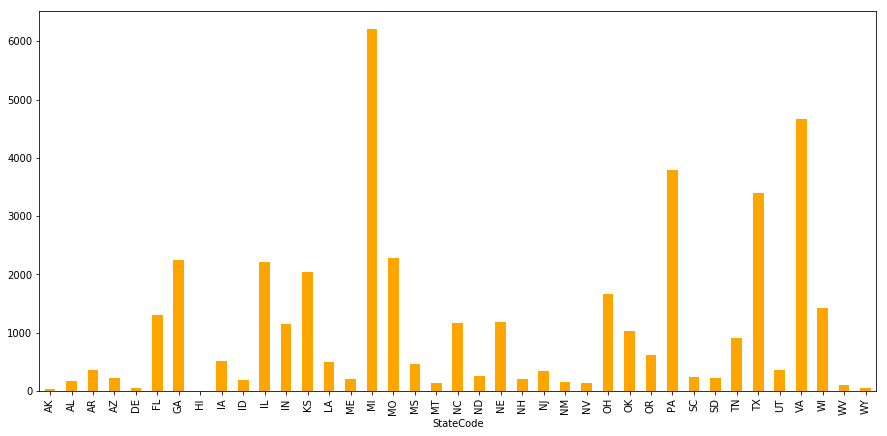

In [16]:
db = client.HealthInsuranceMarketplace
serviceArea = db.ServiceArea

dfSource = pd.DataFrame(list(serviceArea.find()))#Grab the whole ServiceArea
df_final = dfSource.groupby("StateCode")['SourceName'].count()#count the amount of SourceNames per State

df_final.plot.bar(figsize=(15,7), color = 'orange')
# ^ plot the DataFrame
client.close()

# C) Use the “Benefit-Cost Sharing” dataset from MongoDB. Display a table of the names of the plans with the most customers by state, the number of customers for that plan and the total number of customers. (Hint: use Statecode, benefitName)

   StateCode                      BenefitName  count  TotalCustomers
0         AK                Accidental Dental    241           13385
1               Outpatient Facility Fee (e.g.  13651           59806
2         FL        Major Dental Care - Adult   1415           90996
3         AL                Accidental Dental    194            7199
4         AZ        Major Dental Care - Child   1307           81253
5         GA  Routine Dental Services (Adult)    476           26342
6         IN     Dental Check-Up for Children    834           52165
7         LA                Accidental Dental    531           31988
8         WY        Major Dental Care - Adult    160            7720
9         AR        Major Dental Care - Adult    394           21909
10        DE              Orthodontia - Adult    151            6910
11        IL        Basic Dental Care - Adult    733           50275
12        WI  Routine Dental Services (Adult)   1604          109604
13        KS        Basic Dental C

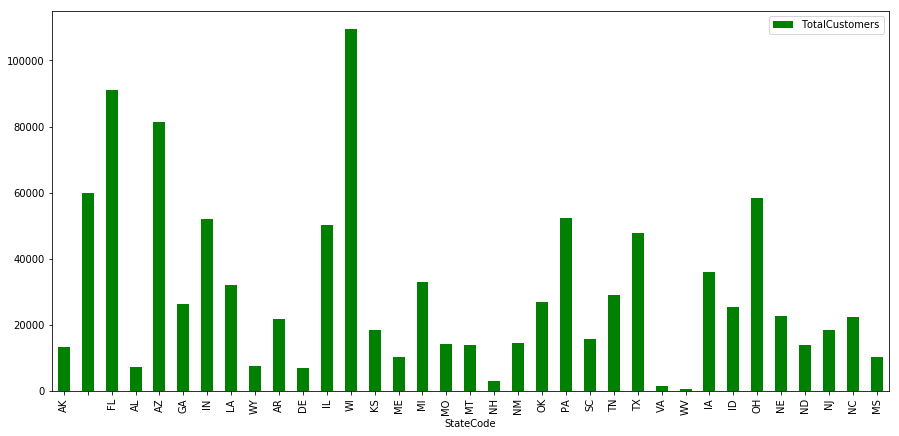

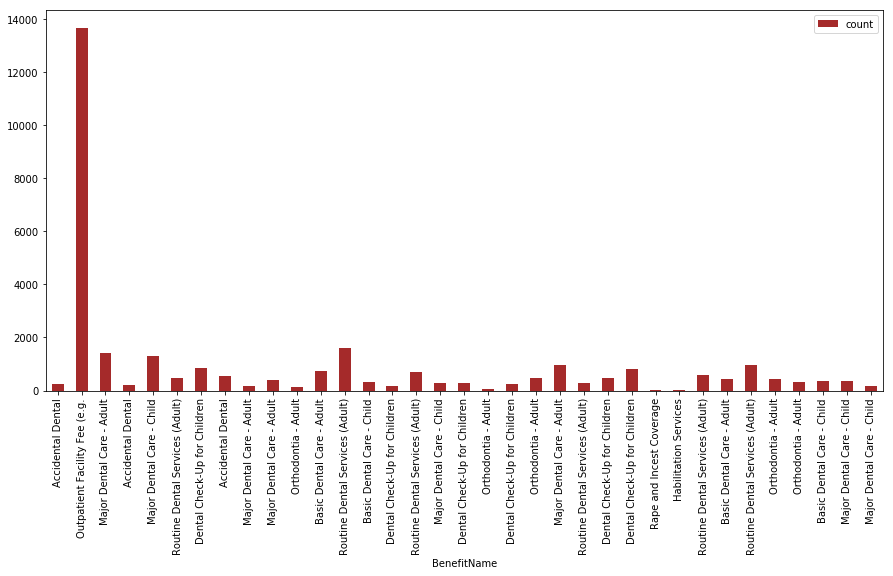

In [15]:
db = client.HealthInsuranceMarketplace
benefitsCostSharing = db.BenefitsCostSharing

state = list(benefitsCostSharing.distinct('StateCode'))#Grab a list of each state in the Table

val_list = []#create a holding list to grab values in the for statement
for st in state:
    query = ([
            { '$match' : {"StateCode" : st} },
            { '$group'  : {'_id': "$BenefitName", 'count': {'$sum': 1}}}])
    # ^ aggregate query to grab the unique BenefitNames and count them per state 
    df_hold = pd.DataFrame(list(benefitsCostSharing.aggregate(query)))#put the results into a temporary holding dataframe
    maxIndex = df_hold['count'].idxmax()#find the max count row id
    maxIndex_val = df_hold.iloc[maxIndex]#pull the whole row information based on the row id
    df_partial = pd.DataFrame(maxIndex_val)#make the output value into a dataframe
    dict_hold = df_partial.to_dict()#convert the dataframe into a dictionary
    removed_value = dict_hold.pop(maxIndex, None)#peel away the outter dictionary and take the result
    removed_value['StateCode'] = st#add the current state to the dictionary
    val_list.append(removed_value)#append the current dictionary in the for loop to the otter list

df_semiFinal = pd.DataFrame(val_list)#take the outter list now filled with dictionaries and turn into semiFinal dataframe
df_semiFinal.rename(columns = {'_id':'BenefitName'}, inplace = True)#rename column for consistancy

#make empty holding dicts and lists
state_dict = {}
stateHold = []
custHold = []

df = pd.DataFrame(list(benefitsCostSharing.find({},{'StateCode':1,'_id':0})))#grab only state codes from benefits table
df_state = df.groupby("StateCode")['StateCode'].count()#group the states and count them
#^ this data frame had no column names just a title/column for both values 
#making it impossible to join on the semi Final DataFrame

#had to convert to dictionary to peel all the '0' keys from the now StateCount dictionary
stateCustCount_dict = df_state.to_dict()
for st in state:#since were still dealing with the same state from the table
    custTotal = stateCustCount_dict.pop(st, None)#take the totals from the states and put into a list
    stateHold.append(st)#append the current state into a list
    custHold.append(custTotal)#append the current total of the for loop state into a list
state_dict['StateCode'] = stateHold#put the full state list into the key of 'StateCode' of the dictionary
state_dict['TotalCustomers'] = custHold#put the full custCount list into the key of 'TotalCustomers' of the dictionary
df_stateFinal = pd.DataFrame(state_dict)#make a clean mergable dataframe from the dictionary

df_final = pd.merge(df_semiFinal, df_stateFinal, on='StateCode', how='outer')
# ^ merge the dataframes together to make the full table

print(df_final)# show table
df_stateFinal.plot.bar(x='StateCode', y='TotalCustomers',color='green',figsize=(15,7))#plot to show some visual
df_semiFinal.plot.bar(x='BenefitName',y='count', color = 'brown',figsize=(15,7))#plot to show some visual

client.close()

# D) Use the “Benefit Cost Sharing” dataset from MongoDB. Find and plot the number of benefit plans in each state.


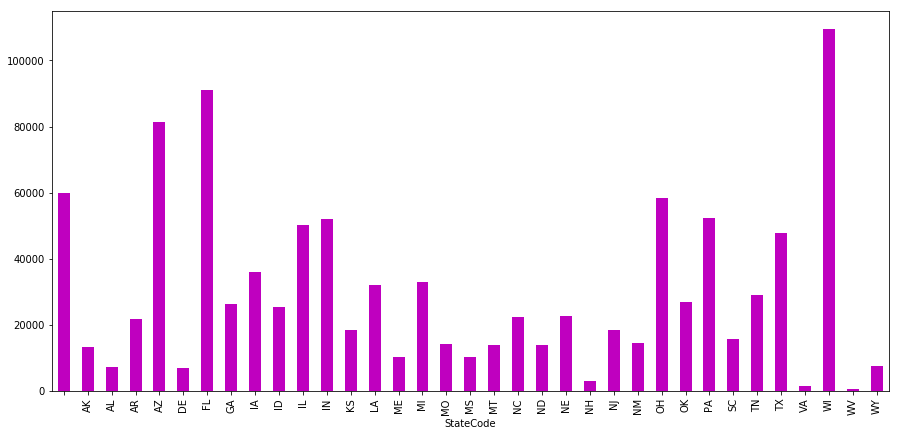

In [17]:
db = client.HealthInsuranceMarketplace
benefitsCostSharing = db.BenefitsCostSharing

df = pd.DataFrame(list(benefitsCostSharing.find()))#grab the whole table/collection form mongo
df_final = df.groupby("StateCode")['BenefitName'].count()#group by state and count by amount of benefit names
#df_final = df.groupby("StateCode")['BenefitName'].nunique() #incase you want to count each unique benefit name by state

df_final.plot(y=['BenefitName'],x=['StateCode'],kind="bar",figsize=(15,7),color='m')

client.close()


# E) Use the “Insurance” dataset from MongoDB and find the number of mothers who smoke and also have children.

The total numer of smoking mothers is: 62


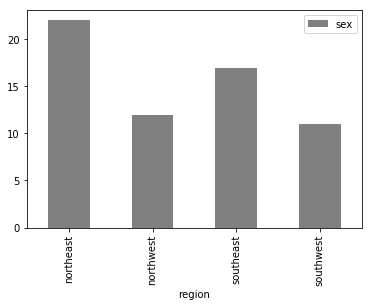

In [14]:
db = client.HealthInsuranceMarketplace
insurance = db.Insurance
query = {'smoker':'yes','sex':'female','children':{'$gt':0}}#query to find the smoking mohters with children
projection = {'region':1,'sex':1,'_id':0}#projection to only get region and sex
smokerDF = pd.DataFrame(list(insurance.find(query,projection)))#take find query and put into data frame
smokerDF = smokerDF.groupby(['region']).count()#take count all the people with the past query and count them per region
Total = smokerDF['sex'].sum()#sum up all the mothers
print(f'The total numer of smoking mothers is: {Total}')#present total
smokerDF.plot.bar(color='gray')#show the smoking mothers per region
client.close()

# F) Use the “Insurance” dataset from MongoDB. Find out which region has the highest rate of smokers. Plot the results for each region.

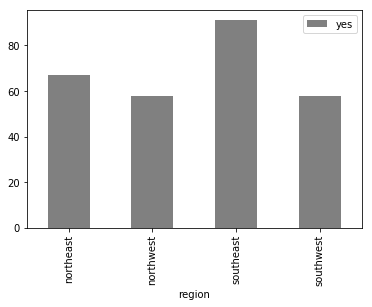

In [16]:
db = client.HealthInsuranceMarketplace
insurance = db.Insurance

projection = {'smoker':1,'region':1,'_id':0}#projection to only show what we want
dfList = []#empty list to fill
snList = list(insurance.distinct('smoker'))#give me 'yes' or 'no' in a list

for i in snList:
    dfList.append(pd.DataFrame(list(insurance.find({'smoker':i}, projection))))#give me each smoker yes or no in a dataframe

client.close()
count = -1
for i in snList:#for eache yes/no dataframe
    count += 1
    dfList[count] = dfList[count].groupby(['region']).count()#count and group by region for yes and no dataframe
    dfList[count].rename(columns = {'smoker':i}, inplace = True)#to give more context for the dataframes

#print(dfList[1]) #if you would like to see smokers per-region
#print(dfList[0]) #if you would like to see non-smokers per-region

dfList[1].plot.bar(color='gray')